# Import necessary dependencies

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# This next code segment captures and stores all of the MFCC data to be dimensionally reduced

In [17]:
directory = 'data/Respiratory_Sound_Database/audio_and_txt_files'
dataset = []
        
sample_rate = 4000
mfcc_size = 13 # size 12-13 is able to capture most of the desired information in terms of variance where values larger than 13 do not add much more information and values smaller than 12 do not capture enough information

for file in os.listdir(directory):
    
    if file.endswith('.wav'):
        file_path = os.path.join(directory, file)

        data, _ = librosa.load(file_path)

        trimmed_data, _ = librosa.effects.trim(y=data)

        mfccs = librosa.feature.mfcc(y=trimmed_data, 
                                        sr=sample_rate, 
                                        n_mfcc=mfcc_size)

        stddev_mfccs = np.std(mfccs, axis=1)

        mean_mfccs = np.mean(mfccs, axis=1)

        average_difference = np.zeros((mfcc_size,))
        for i in range(0, len(mfccs.T) - 2, 2):
            average_difference += mfccs.T[i] - mfccs.T[i+1]
        average_difference /= (len(mfccs) // 2)   
        average_difference = np.array(average_difference)

        concat_features = np.hstack((stddev_mfccs, mean_mfccs))
        concat_features = np.hstack((concat_features, average_difference))
        
        dataset += [(file, concat_features)]

# This code segment prepares the data to be plotted and to be stored as json for potential HTML visualizations

In [12]:
all_file_paths, mfcc_features = zip(*dataset)
    
mfcc_features = np.array(mfcc_features)

mfcc_tuples = []

all_json = dict()
all_json["filenames"] = all_file_paths

print(len(all_file_paths), 
      mfcc_features.shape)

920 (920, 6)


# The code segment below constructs the plot for the MFCC features using PCA

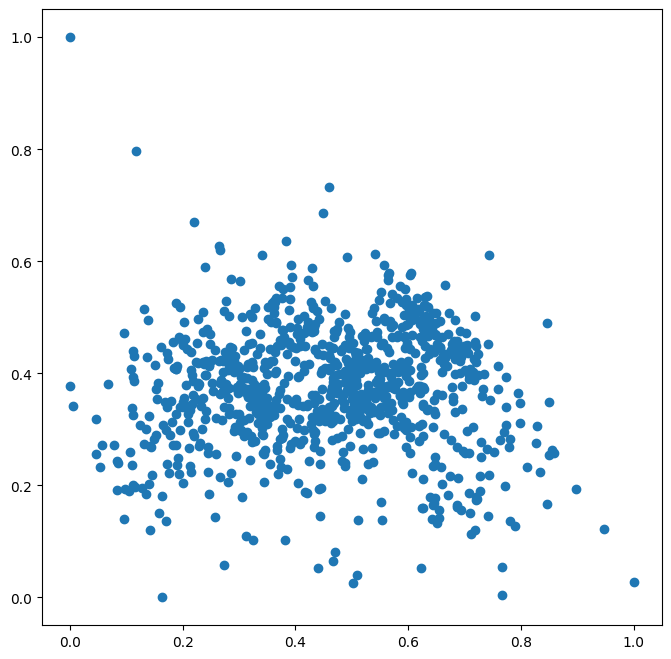

In [16]:
def transform_numpy_to_json(array):
    data = []
    for position in array:
        data.append({
            'coordinates': position.tolist()
        })
    return data

def get_pca(features):
    if features.shape[1] == 2: # if the mfcc_features already has dimensionality 2, we can optionally skip PCA and just scale the data as implementing PCA will not affect the output
        scaler = MinMaxScaler()
        return scaler.fit(features)
    else:
        pca = PCA(n_components=2)
        transformed = pca.fit(features).transform(features)
        scaler = MinMaxScaler()
        scaler.fit(transformed)
        return scaler.transform(transformed)

pca_mfcc = get_pca(mfcc_features)

mfcc_key = 'pcamfcc'

all_json[mfcc_key] = transform_numpy_to_json(pca_mfcc)


### Plotting the data
plt.figure(figsize=(8, 8))
_ = plt.scatter(pca_mfcc.T[0],
                pca_mfcc.T[1])
plt.show()

# The code segment below constructs and plots the t-SNE embeddings

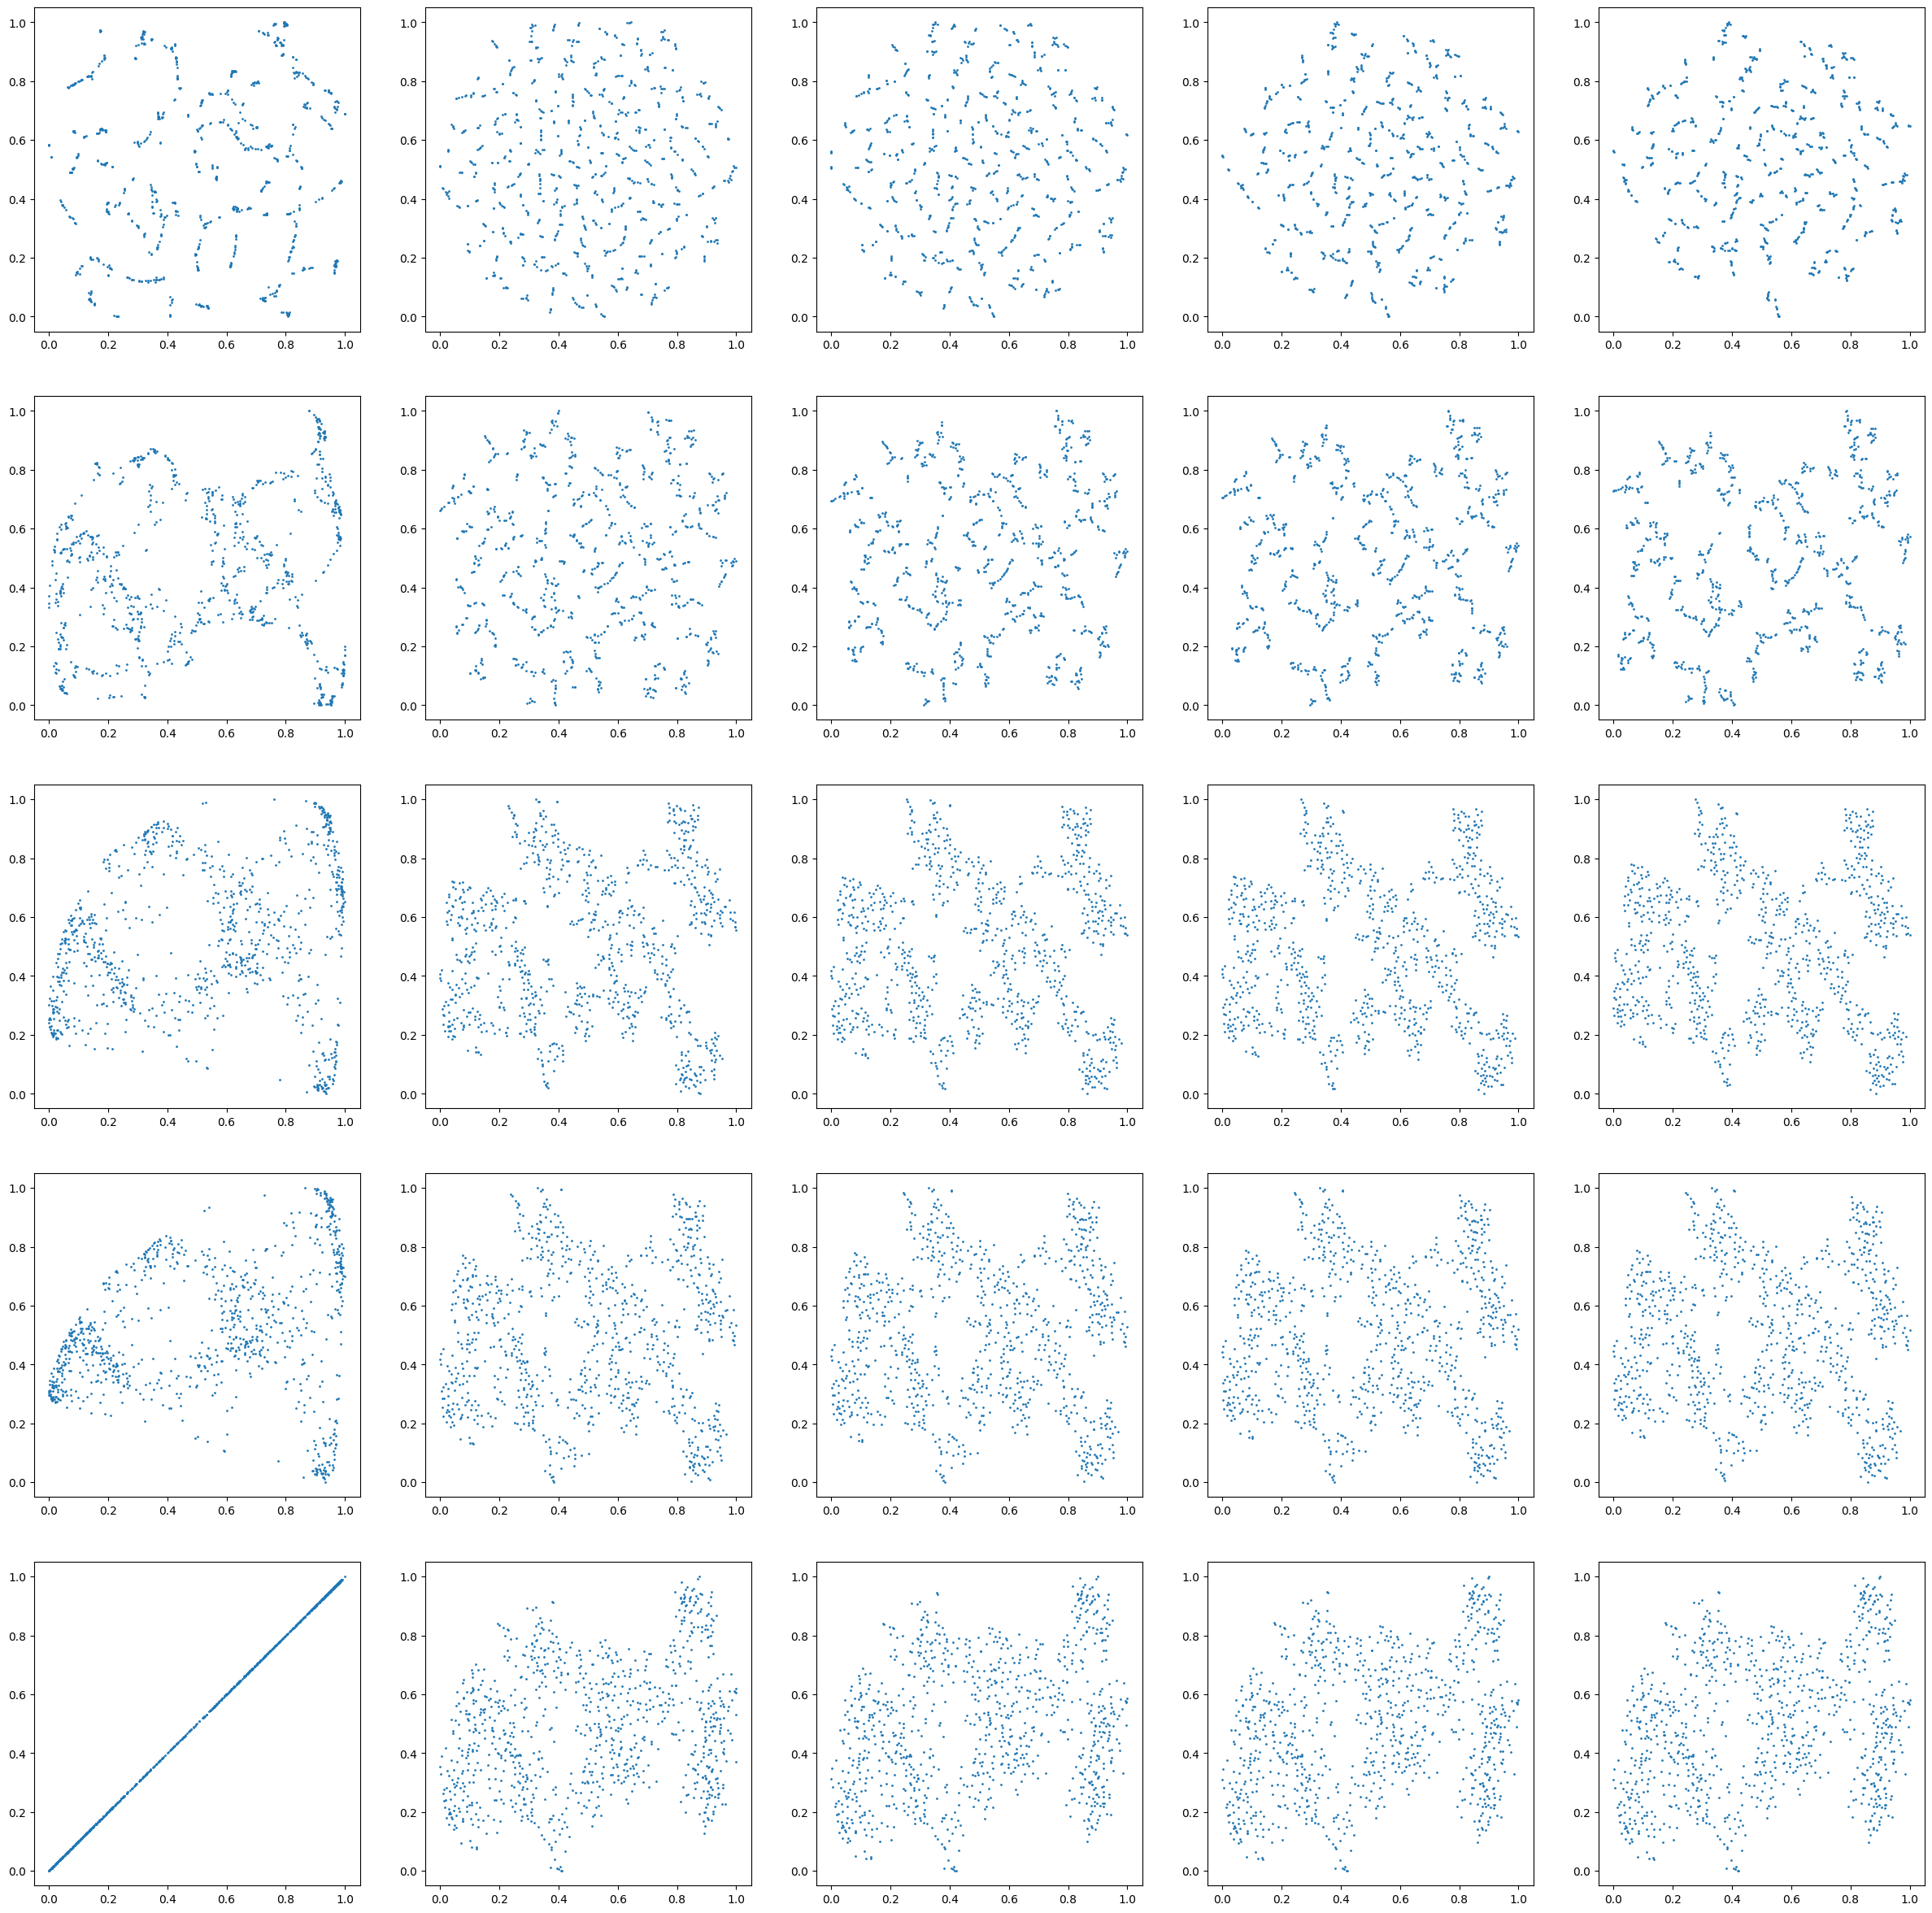

In [20]:
def get_scaled_tsne_embeddings(features, perplexity, iteration):
    embedding = TSNE(n_components=2,
                     perplexity=perplexity,
                     n_iter=iteration).fit_transform(features)
    scaler = MinMaxScaler()
    scaler.fit(embedding)
    return scaler.transform(embedding)


def transform_numpy_to_json(array):
    data = []
    for position in array:
        data.append({
            'coordinates': position.tolist()
        })
    return data


tnse_embeddings_mfccs = []
# tnse_embeddings_wavenet = []
perplexities = [2, 5, 30, 50, 100]
iterations = [250, 500, 1000, 2000, 5000]
for i, perplexity in enumerate(perplexities):
    for j, iteration in enumerate(iterations):
        tsne_mfccs = get_scaled_tsne_embeddings(mfcc_features, perplexity, iteration)
        
        tnse_embeddings_mfccs.append(tsne_mfccs)
        
        mfcc_key = 'tsnemfcc{}{}'.format(i, j) 
        
        all_json[mfcc_key] = transform_numpy_to_json(tsne_mfccs)


### Plotting the data
fig, ax = plt.subplots(nrows=len(perplexities), 
                       ncols=len(iterations),
                       figsize=(30, 30))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        current_plot = i * len(iterations) + j
        col.scatter(tnse_embeddings_mfccs[current_plot].T[0], 
                    tnse_embeddings_mfccs[current_plot].T[1], 
                    s=1)
plt.show()